In [1]:
import pandas as pd
pd.set_option("display.max_columns", 150)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import shap
import xgboost


In [2]:
citibike = pd.read_csv('../data/citibike_vis.csv')
citibike  = citibike.drop(columns = 'Unnamed: 0') #dropping extra column
citibike = citibike.sort_values('date').reset_index(drop = True) #sorting the values by date and resetting index.

In [3]:
citibike['date'] = pd.to_datetime(citibike['date'])
citibike['day_of_week'] = citibike['day_of_week'].astype(str) #changing the day of week column to string.
citibike['month'] = pd.to_datetime(citibike['date']).dt.month

In [4]:
citibike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1095 non-null   datetime64[ns]
 1   num_of_trips          1095 non-null   int64         
 2   holiday               1095 non-null   bool          
 3   prcp                  1095 non-null   int64         
 4   snow                  1095 non-null   float64       
 5   awnd                  972 non-null    float64       
 6   rhav                  1084 non-null   float64       
 7   rhmn                  1084 non-null   float64       
 8   rhmx                  1084 non-null   float64       
 9   tmax                  1095 non-null   float64       
 10  tmin                  1095 non-null   float64       
 11  tavg                  1095 non-null   float64       
 12  median_trip_duration  1095 non-null   float64       
 13  mean_trip_duration

In [5]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

In [6]:
linreg = LinearRegression()

predictors = ['tmax']

X = citibike[predictors]
y = citibike['num_of_trips'] 

#splitting the X and y varibles for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 117)

linreg_temp = linreg.fit(X_train, y_train)
y_pred = linreg_temp.predict(X_test)

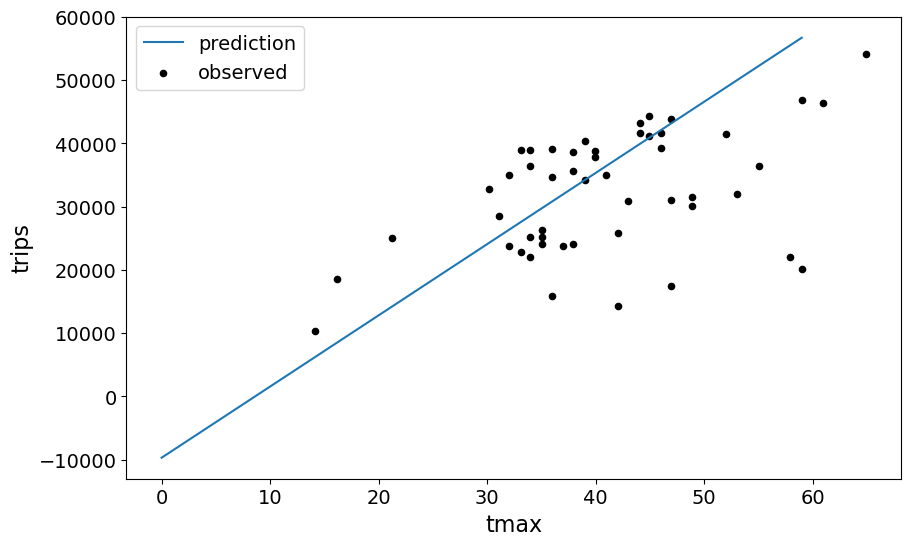

In [7]:
x_grid = np.linspace(start = 0, stop = np.max(citibike['tmax'].head(25)))
x_grid = pd.DataFrame({
    'tmax': x_grid
})
y_grid = linreg.predict(x_grid)

fontsize = 16

fig, ax = plt.subplots(figsize = (10,6))


plt.plot(x_grid, y_grid, label = 'prediction')

citibike.head(50).plot(kind = 'scatter',
                    x = 'tmax',
                    y = 'num_of_trips',
                    ax = ax,
                    color = 'black',
                    label = 'observed')

plt.legend(fontsize = fontsize - 2)


plt.xlabel('tmax', fontsize = fontsize)
plt.ylabel('trips', fontsize = fontsize)
plt.xticks(fontsize = fontsize - 2)
plt.yticks(fontsize = fontsize - 2);

In [8]:
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))
print(y_test.std())

391875904.54565287
15413.98201547318
0.4938316460514631
27875.37660768082


In [9]:
predictors = ['tmax', 'is_snow', 'did_rain', 'day_of_week', 'holiday', 'season', 'month', 'awnd', 'rhav', 'rhmn', 'rhmx', 'tavg', 'event_happened']
cat_predictors = ['is_snow', 'did_rain', 'day_of_week', 'holiday', 'season', 'month', 'event_happened']
num_predictors = ['tmax', 'rhav', 'rhmn', 'rhmx', 'tavg', 'awnd']

X = citibike[predictors]
X = pd.get_dummies(X, columns = cat_predictors)
y = citibike['num_of_trips']

# Splitting the X and y variables for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

# Creating the scaler and imputer
scaler = StandardScaler()
iterative_imputer = IterativeImputer()

# Fit the scaler and imputer on the training set
X_train_num = scaler.fit_transform(X_train[num_predictors])
X_train_num = iterative_imputer.fit_transform(X_train_num)

# the same transformations to the test set
X_test_num = scaler.transform(X_test[num_predictors])
X_test_num = iterative_imputer.transform(X_test_num)

X_train.loc[:, num_predictors] = X_train_num
X_test.loc[:, num_predictors] = X_test_num

#linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on the test set
y_pred_all = linreg.predict(X_test)


[IterativeImputer] Early stopping criterion not reached.


In [10]:
print(f'MSE: {mean_squared_error(y_test, y_pred_all)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_all)}')
print(f'R^2: {r2_score(y_test, y_pred_all)}')
print(f'std: {y_test.std()}')

MSE: 250510726.84854016
MAE: 12232.689781021898
R^2: 0.6764266422494343
std: 27875.37660768082


In [11]:
xgb = xgboost.XGBRegressor(tree_method="hist", enable_categorical = True).fit(X_train, y_train)

print(f'R2: {r2_score(y_test, xgb.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test, xgb.predict(X_test))}')

R2: 0.6887700786472395
MAE: 12097.076221772353


In [12]:
explainer = shap.TreeExplainer(xgb)
explanation = explainer(X_test)

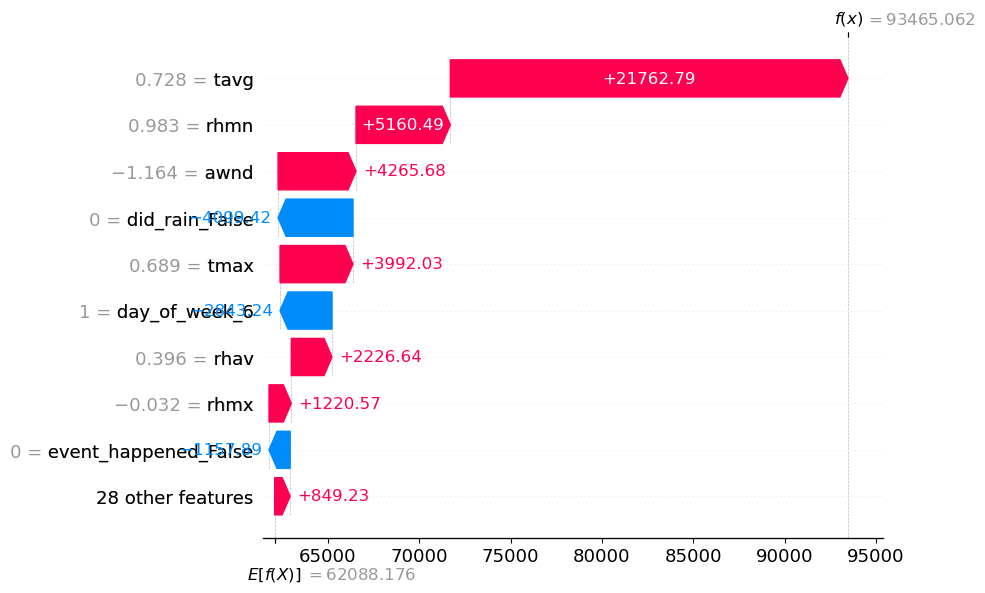

In [13]:
i = 1

shap.plots.waterfall(explanation[i])

In [14]:
shap.plots.initjs()

i = 1
shap.plots.force(explanation[i])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


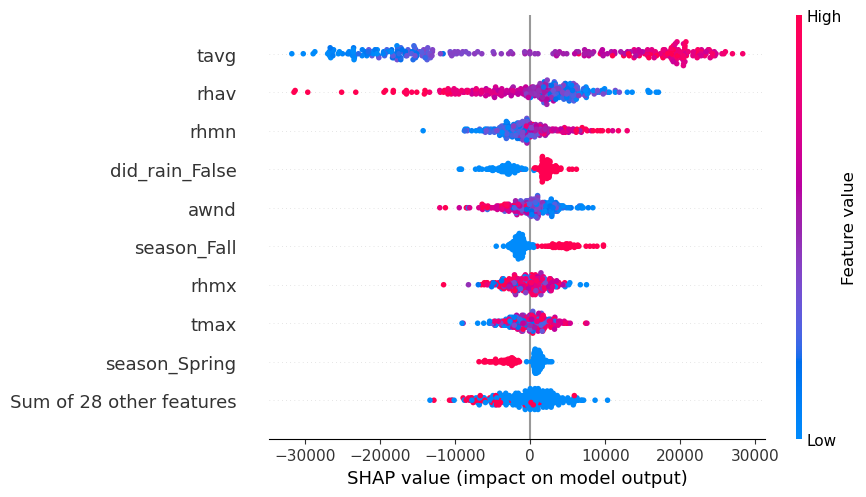

In [15]:
shap.plots.beeswarm(explanation)

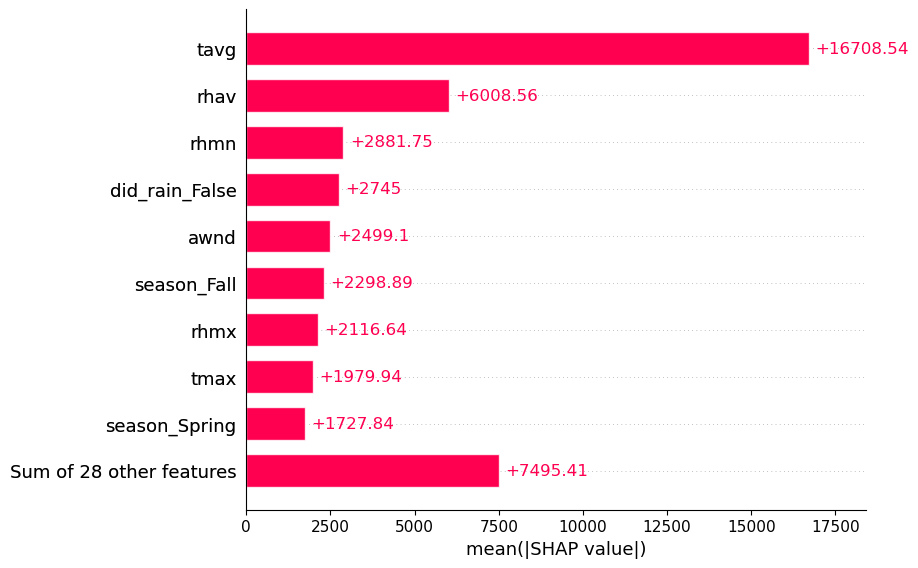

In [16]:
shap.plots.bar(explanation)

In [ ]:
x_train_trips  = citibike.loc[X_train.index].groupby('season')['num_of_trips'].mean().reset_index()

x_train_trips = x_train_trips.rename(columns = {'num_of_trips' : 'predictions'})

In [ ]:
 season_trip2 = x_train_trips.set_index('season').to_dict()['predictions']

In [ ]:
X_test_trips  = citibike.loc[X_test.index]

In [ ]:
 predictions_season  = X_test_trips['season'].map(season_trip2)

In [ ]:
r2_score(y_test, predictions_season)

In [ ]:
X_test

In [ ]:
pd.merge(x_train_trips, X_test_trips)

In [ ]:
citibike

In [ ]:
predictors = ['tmax','is_snow', 'did_rain', 'day_of_week', 'holiday', 'season', 'month']
cat_predictors = ['is_snow', 'did_rain', 'day_of_week', 'holiday', 'season', 'month']

X = citibike[predictors]
X = pd.get_dummies(X, columns = cat_predictors)
y = citibike['num_of_trips'] 

#splitting the X and y varibles for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 117)

linreg_all = linreg.fit(X_train, y_train)
y_pred_all = linreg_all.predict(X_test)

In [ ]:
print(f'MSE: {mean_squared_error(y_test, y_pred_all)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_all)}')
print(f'R^2: {r2_score(y_test, y_pred_all)}')
print(f'std: {y_test.std()}')

In [17]:
predictors = ['tmax','did_rain', 'season', 'awnd', 'rhav', 'rhmn', 'tavg']
cat_predictors = ['did_rain', 'season']
num_predictors = ['tmax', 'rhav', 'rhmn', 'tavg', 'awnd']

X = citibike[predictors]
X = pd.get_dummies(X, columns = cat_predictors)
y = citibike['num_of_trips']

# Splitting the X and y variables for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

# Creating the scaler and imputer
scaler = StandardScaler()
iterative_imputer = IterativeImputer()

# Fit the scaler and imputer on the training set
X_train_num = scaler.fit_transform(X_train[num_predictors])
X_train_num = iterative_imputer.fit_transform(X_train_num)

# the same transformations to the test set
X_test_num = scaler.transform(X_test[num_predictors])
X_test_num = iterative_imputer.transform(X_test_num)

X_train.loc[:, num_predictors] = X_train_num
X_test.loc[:, num_predictors] = X_test_num

#linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on the test set
y_pred_all = linreg.predict(X_test)


[IterativeImputer] Early stopping criterion not reached.


In [18]:
print(f'MSE: {mean_squared_error(y_test, y_pred_all)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_all)}')
print(f'R^2: {r2_score(y_test, y_pred_all)}')
print(f'std: {y_test.std()}')

MSE: 247327506.67281836
MAE: 12405.113001767919
R^2: 0.6805382635507463
std: 27875.37660768082


In [19]:
xgb = xgboost.XGBRegressor(tree_method="hist", enable_categorical = True).fit(X_train, y_train)

print(f'R2: {r2_score(y_test, xgb.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test, xgb.predict(X_test))}')

R2: 0.6823426528713211
MAE: 12031.639001553945
